In [ ]:
# Cell 1: Install required packages
!pip install scikit-image opencv-python matplotlib pillow

In [ ]:
# Cell 2: Import libraries and setup
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from google.colab.patches import cv2_imshow
from google.colab import files
from PIL import Image
import io
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")

All libraries imported successfully!


In [ ]:
# Cell 3: Image upload function
def upload_image():
    """Upload an image file and return it as a numpy array."""
    print("Please upload your crop field image with RED LINE boundary marking:")
    uploaded = files.upload()

    # Get the uploaded file
    filename = list(uploaded.keys())[0]

    # Read and convert the image
    image = Image.open(io.BytesIO(uploaded[filename]))
    image = np.array(image)

    # Convert to BGR if needed (PIL uses RGB, OpenCV uses BGR)
    if len(image.shape) == 3 and image.shape[2] == 3:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    print(f"Image uploaded successfully! Shape: {image.shape}")
    return image, filename

# Call the upload function
original_image, image_name = upload_image()

Please upload your crop field image with RED LINE boundary marking:


Saving WhatsApp Image 2025-08-06 at 14.13.29_48aba684.jpg to WhatsApp Image 2025-08-06 at 14.13.29_48aba684.jpg
Image uploaded successfully! Shape: (720, 1280, 3)


In [ ]:
# Cell 4: Red line detection functions
def detect_red_boundary(image):
    """
    Detect red line boundary marking in the image.
    Returns the red line mask and cleaned field area.
    """
    # Convert to HSV for better color detection
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define red color ranges in HSV
    # Red color has two ranges in HSV due to circular nature of hue
    lower_red1 = np.array([0, 50, 50])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([170, 50, 50])
    upper_red2 = np.array([180, 255, 255])

    # Create masks for both red ranges
    mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv, lower_red2, upper_red2)

    # Combine both masks
    red_mask = cv2.bitwise_or(mask1, mask2)

    # Clean up the red line detection
    kernel = np.ones((3, 3), np.uint8)
    red_mask = cv2.morphologyEx(red_mask, cv2.MORPH_CLOSE, kernel)
    red_mask = cv2.morphologyEx(red_mask, cv2.MORPH_OPEN, kernel)

    return red_mask

def create_field_mask_from_red_boundary(red_mask, image_shape):
    """
    Create field area mask from red boundary lines.
    Uses contour detection and filling to create the field area.
    """
    # Find contours in the red mask
    contours, _ = cv2.findContours(red_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create field mask
    field_mask = np.zeros((image_shape[0], image_shape[1]), dtype=np.uint8)

    if contours:
        # Find the largest contour (main field boundary)
        largest_contour = max(contours, key=cv2.contourArea)

        # Check if the contour is closed, if not, try to close it
        if not cv2.isContourConvex(largest_contour):
            # Fill the area inside the contour
            cv2.fillPoly(field_mask, [largest_contour], 255)
        else:
            # For open contours, try to create a convex hull
            hull = cv2.convexHull(largest_contour)
            cv2.fillPoly(field_mask, [hull], 255)

        # If we have multiple contours, combine them
        if len(contours) > 1:
            for contour in contours:
                if cv2.contourArea(contour) > 1000:  # Filter small contours
                    cv2.fillPoly(field_mask, [contour], 255)

    # Clean up the field mask
    kernel_large = np.ones((15, 15), np.uint8)
    field_mask = cv2.morphologyEx(field_mask, cv2.MORPH_CLOSE, kernel_large)

    # Fill holes in the field mask
    contours, _ = cv2.findContours(field_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        cv2.fillPoly(field_mask, [contour], 255)

    return field_mask

def alternative_red_boundary_detection(image, sensitivity='medium'):
    """
    Alternative red detection with adjustable sensitivity.
    """
    # Convert to different color spaces for better detection
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Set sensitivity parameters
    if sensitivity == 'low':
        hue_range = 5
        sat_min = 80
        val_min = 80
    elif sensitivity == 'high':
        hue_range = 15
        sat_min = 30
        val_min = 30
    else:  # medium
        hue_range = 10
        sat_min = 50
        val_min = 50

    # Red detection in HSV
    lower_red1 = np.array([0, sat_min, val_min])
    upper_red1 = np.array([hue_range, 255, 255])
    lower_red2 = np.array([180-hue_range, sat_min, val_min])
    upper_red2 = np.array([180, 255, 255])

    mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
    red_mask_hsv = cv2.bitwise_or(mask1, mask2)

    # Red detection in LAB color space (A channel)
    a_channel = lab[:,:,1]
    _, red_mask_lab = cv2.threshold(a_channel, 135, 255, cv2.THRESH_BINARY)

    # Combine both approaches
    combined_red_mask = cv2.bitwise_or(red_mask_hsv, red_mask_lab)

    # Clean up
    kernel = np.ones((3, 3), np.uint8)
    combined_red_mask = cv2.morphologyEx(combined_red_mask, cv2.MORPH_CLOSE, kernel)

    return combined_red_mask

# Test red boundary detection
red_boundary_mask = detect_red_boundary(original_image)
red_boundary_alt = alternative_red_boundary_detection(original_image, 'medium')

print("Red boundary detection completed!")
print(f"Red pixels detected (method 1): {np.count_nonzero(red_boundary_mask)}")
print(f"Red pixels detected (method 2): {np.count_nonzero(red_boundary_alt)}")

Red boundary detection completed!
Red pixels detected (method 1): 17044
Red pixels detected (method 2): 51933


In [ ]:
# Cell 5: Enhanced field area detection using red boundaries
def detect_field_area_with_red_boundary(image, red_method='combined'):
    """
    Detect field area using red boundary lines as guidance.
    """
    # Get red boundary mask
    if red_method == 'hsv':
        red_mask = detect_red_boundary(image)
    elif red_method == 'alternative':
        red_mask = alternative_red_boundary_detection(image, 'medium')
    else:  # combined
        red_mask1 = detect_red_boundary(image)
        red_mask2 = alternative_red_boundary_detection(image, 'medium')
        red_mask = cv2.bitwise_or(red_mask1, red_mask2)

    # Create field mask from red boundary
    field_mask = create_field_mask_from_red_boundary(red_mask, image.shape)

    # If no field detected, try alternative approach
    if np.count_nonzero(field_mask) < 1000:
        print("Warning: Low red boundary detection. Trying alternative approach...")

        # Try with higher sensitivity
        red_mask_high = alternative_red_boundary_detection(image, 'high')
        field_mask = create_field_mask_from_red_boundary(red_mask_high, image.shape)

        # If still no good detection, use contour-based approach
        if np.count_nonzero(field_mask) < 1000:
            # Find red pixels and create bounding area
            if np.count_nonzero(red_mask) > 50:
                # Get bounding rectangle of red pixels
                coords = np.column_stack(np.where(red_mask > 0))
                if len(coords) > 0:
                    y_min, x_min = coords.min(axis=0)
                    y_max, x_max = coords.max(axis=0)

                    # Create rectangular field mask
                    field_mask = np.zeros(image.shape[:2], dtype=np.uint8)
                    field_mask[y_min:y_max, x_min:x_max] = 255

    # Remove red boundary lines from field mask (clean the interior)
    field_mask_clean = cv2.bitwise_and(field_mask, cv2.bitwise_not(red_mask))

    # Fill small holes created by removing red lines
    kernel = np.ones((10, 10), np.uint8)
    field_mask_clean = cv2.morphologyEx(field_mask_clean, cv2.MORPH_CLOSE, kernel)

    # Calculate area
    area_pixels = np.count_nonzero(field_mask_clean)
    total_pixels = image.shape[0] * image.shape[1]
    area_percent = (area_pixels / total_pixels) * 100

    return field_mask_clean, red_mask, area_pixels, area_percent

# Test field detection with red boundaries
field_mask, red_lines, field_pixels, field_percentage = detect_field_area_with_red_boundary(original_image, 'combined')

print(f"Field detection with red boundaries completed!")
print(f"Red boundary pixels: {np.count_nonzero(red_lines):,}")
print(f"Field area: {field_percentage:.2f}% ({field_pixels:,} pixels)")

Field detection with red boundaries completed!
Red boundary pixels: 51,933
Field area: 23.25% (214,232 pixels)


In [ ]:
# Cell 6: Enhanced path detection within field area
def detect_paths_in_field(image, field_mask, red_boundary_mask):
    """
    Detect navigable paths specifically within the field area,
    excluding red boundary lines.
    """
    # Convert to grayscale
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()

    # Enhance contrast using CLAHE
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)

    # Apply field mask to focus only on field area
    field_gray = cv2.bitwise_and(enhanced, enhanced, mask=field_mask)

    # Remove red boundary areas from path detection
    clean_mask = cv2.bitwise_and(field_mask, cv2.bitwise_not(red_boundary_mask))
    field_gray_clean = cv2.bitwise_and(field_gray, field_gray, mask=clean_mask)

    # Path detection using adaptive thresholding
    binary = cv2.adaptiveThreshold(field_gray_clean, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                   cv2.THRESH_BINARY_INV, 31, 15)

    # Clean up binary image
    kernel = np.ones((5, 5), np.uint8)
    opened = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

    # Apply field mask again to ensure paths are only within field
    paths_in_field = cv2.bitwise_and(opened, opened, mask=clean_mask)

    # Skeletonization to refine paths
    if np.count_nonzero(paths_in_field) > 0:
        skel = skeletonize(paths_in_field // 255)
        skeleton = skel.astype(np.uint8) * 255
    else:
        skeleton = np.zeros_like(paths_in_field)

    return paths_in_field, skeleton

def detect_paths_multiple_methods(image, field_mask, red_boundary_mask):
    """
    Multiple methods for path detection within field area.
    """
    # Convert to grayscale
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()

    # Create clean field area (without red boundaries)
    clean_field_mask = cv2.bitwise_and(field_mask, cv2.bitwise_not(red_boundary_mask))

    # Method 1: Adaptive thresholding
    enhanced = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8)).apply(gray)
    field_enhanced = cv2.bitwise_and(enhanced, enhanced, mask=clean_field_mask)

    binary1 = cv2.adaptiveThreshold(field_enhanced, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                   cv2.THRESH_BINARY_INV, 31, 15)
    paths1 = cv2.bitwise_and(binary1, binary1, mask=clean_field_mask)

    # Method 2: Gaussian adaptive thresholding
    binary2 = cv2.adaptiveThreshold(field_enhanced, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 31, 15)
    paths2 = cv2.bitwise_and(binary2, binary2, mask=clean_field_mask)

    # Method 3: Otsu thresholding within field
    _, binary3 = cv2.threshold(field_enhanced, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    paths3 = cv2.bitwise_and(binary3, binary3, mask=clean_field_mask)

    # Combine methods using majority voting
    combined = (paths1.astype(np.float32) + paths2.astype(np.float32) + paths3.astype(np.float32)) / 3
    final_paths = (combined > 0.4).astype(np.uint8) * 255

    # Clean up
    kernel = np.ones((3, 3), np.uint8)
    final_paths = cv2.morphologyEx(final_paths, cv2.MORPH_OPEN, kernel)

    # Skeletonize
    if np.count_nonzero(final_paths) > 0:
        skel = skeletonize(final_paths // 255)
        skeleton = skel.astype(np.uint8) * 255
    else:
        skeleton = np.zeros_like(final_paths)

    return final_paths, skeleton

# Detect paths within the field area
path_binary, path_skeleton = detect_paths_in_field(original_image, field_mask, red_lines)
path_binary_multi, path_skeleton_multi = detect_paths_multiple_methods(original_image, field_mask, red_lines)

print("Path detection within field completed!")
print(f"Path pixels (method 1): {np.count_nonzero(path_skeleton):,}")
print(f"Path pixels (method 2): {np.count_nonzero(path_skeleton_multi):,}")


Path detection within field completed!
Path pixels (method 1): 3,022
Path pixels (method 2): 10,229


In [ ]:
# Cell 7: Advanced red boundary analysis
def analyze_red_boundary_quality(red_mask, image_shape):
    """
    Analyze the quality and completeness of red boundary detection.
    """
    # Calculate basic metrics
    total_pixels = image_shape[0] * image_shape[1]
    red_pixel_count = np.count_nonzero(red_mask)
    red_percentage = (red_pixel_count / total_pixels) * 100

    # Find contours to analyze boundary structure
    contours, _ = cv2.findContours(red_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    analysis_results = {
        'red_pixel_count': red_pixel_count,
        'red_percentage': red_percentage,
        'num_contours': len(contours),
        'boundary_quality': 'Unknown'
    }

    if contours:
        # Find largest contour (main boundary)
        largest_contour = max(contours, key=cv2.contourArea)
        contour_area = cv2.contourArea(largest_contour)
        contour_perimeter = cv2.arcLength(largest_contour, True)

        analysis_results.update({
            'largest_contour_area': contour_area,
            'contour_perimeter': contour_perimeter,
            'contour_compactness': contour_perimeter / np.sqrt(contour_area) if contour_area > 0 else 0
        })

        # Determine boundary quality
        if red_pixel_count > 500 and len(contours) <= 3:
            analysis_results['boundary_quality'] = 'Good'
        elif red_pixel_count > 100:
            analysis_results['boundary_quality'] = 'Fair'
        else:
            analysis_results['boundary_quality'] = 'Poor'

    return analysis_results

def improve_red_detection_iteratively(image, max_iterations=3):
    """
    Iteratively improve red detection using different parameters.
    """
    best_mask = None
    best_score = 0
    best_method = ""

    methods = [
        ('hsv_default', lambda img: detect_red_boundary(img)),
        ('alt_low', lambda img: alternative_red_boundary_detection(img, 'low')),
        ('alt_medium', lambda img: alternative_red_boundary_detection(img, 'medium')),
        ('alt_high', lambda img: alternative_red_boundary_detection(img, 'high')),
    ]

    results = {}

    for method_name, method_func in methods:
        try:
            mask = method_func(image)
            analysis = analyze_red_boundary_quality(mask, image.shape)

            # Score based on red pixel count and boundary quality
            score = analysis['red_pixel_count']
            if analysis['boundary_quality'] == 'Good':
                score *= 2
            elif analysis['boundary_quality'] == 'Fair':
                score *= 1.5

            results[method_name] = {
                'mask': mask,
                'analysis': analysis,
                'score': score
            }

            if score > best_score:
                best_score = score
                best_mask = mask
                best_method = method_name

        except Exception as e:
            print(f"Method {method_name} failed: {e}")

    return best_mask, best_method, results

# Analyze and improve red boundary detection
best_red_mask, best_method, red_detection_results = improve_red_detection_iteratively(original_image)

print("Red boundary analysis completed!")
print(f"Best method: {best_method}")
for method, result in red_detection_results.items():
    analysis = result['analysis']
    print(f"{method}: {analysis['red_pixel_count']} pixels ({analysis['boundary_quality']} quality)")

Red boundary analysis completed!
Best method: alt_high
hsv_default: 17044 pixels (Fair quality)
alt_low: 48848 pixels (Fair quality)
alt_medium: 51933 pixels (Fair quality)
alt_high: 120677 pixels (Fair quality)


In [ ]:
#Cell 8: Create comprehensive overlay visualization
def create_enhanced_overlay(original, field_mask, red_boundary, path_skeleton):
    """
    Create enhanced overlay visualization with red boundaries, field area, and paths.
    """
    # Convert to BGR if needed
    if len(original.shape) == 3:
        overlay = original.copy()
    else:
        overlay = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)

    # Create color layers
    field_overlay = np.zeros_like(overlay)
    boundary_overlay = np.zeros_like(overlay)
    path_overlay = np.zeros_like(overlay)

    # Field area in semi-transparent green
    field_overlay[field_mask > 0] = [0, 255, 0]  # Green

    # Red boundaries in bright red
    boundary_overlay[red_boundary > 0] = [0, 0, 255]  # Red

    # Paths in blue
    path_overlay[path_skeleton > 0] = [255, 0, 0]  # Blue

    # Combine overlays with different transparency levels
    result = cv2.addWeighted(overlay, 0.6, field_overlay, 0.3, 0)
    result = cv2.addWeighted(result, 0.8, boundary_overlay, 0.7, 0)
    result = cv2.addWeighted(result, 0.9, path_overlay, 0.8, 0)

    return result

def create_analysis_overlay(original, field_mask, red_boundary, path_skeleton):
    """
    Create detailed analysis overlay with statistics.
    """
    overlay = create_enhanced_overlay(original, field_mask, red_boundary, path_skeleton)

    # Add text information
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.7
    color = (255, 255, 255)
    thickness = 2

    # Calculate statistics
    total_pixels = original.shape[0] * original.shape[1]
    field_pixels = np.count_nonzero(field_mask)
    red_pixels = np.count_nonzero(red_boundary)
    path_pixels = np.count_nonzero(path_skeleton)

    field_percent = (field_pixels / total_pixels) * 100
    path_density = (path_pixels / field_pixels) * 100 if field_pixels > 0 else 0

    # Add text overlay
    y_offset = 30
    texts = [
        f"Field Area: {field_percent:.1f}% ({field_pixels:,} pixels)",
        f"Red Boundary: {red_pixels:,} pixels",
        f"Path Density: {path_density:.2f}%",
        f"Total Paths: {path_pixels:,} pixels"
    ]

    for i, text in enumerate(texts):
        y_pos = y_offset + (i * 25)
        cv2.putText(overlay, text, (10, y_pos), font, font_scale, color, thickness)

    return overlay

# Create final visualizations
if best_red_mask is not None:
    final_field_mask, _, final_field_pixels, final_field_percent = detect_field_area_with_red_boundary(
        original_image, 'combined')
    final_path_binary, final_path_skeleton = detect_paths_multiple_methods(
        original_image, final_field_mask, best_red_mask)

    enhanced_overlay = create_enhanced_overlay(original_image, final_field_mask,
                                             best_red_mask, final_path_skeleton)
    analysis_overlay = create_analysis_overlay(original_image, final_field_mask,
                                             best_red_mask, final_path_skeleton)

    print("Enhanced visualization created!")
    print(f"Final field area: {final_field_percent:.2f}%")
    print(f"Final path pixels: {np.count_nonzero(final_path_skeleton):,}")
else:
    print("Warning: No red boundary detected. Using fallback visualization.")
    enhanced_overlay = original_image.copy()
    analysis_overlay = original_image.copy()

Enhanced visualization created!
Final field area: 23.25%
Final path pixels: 6,567


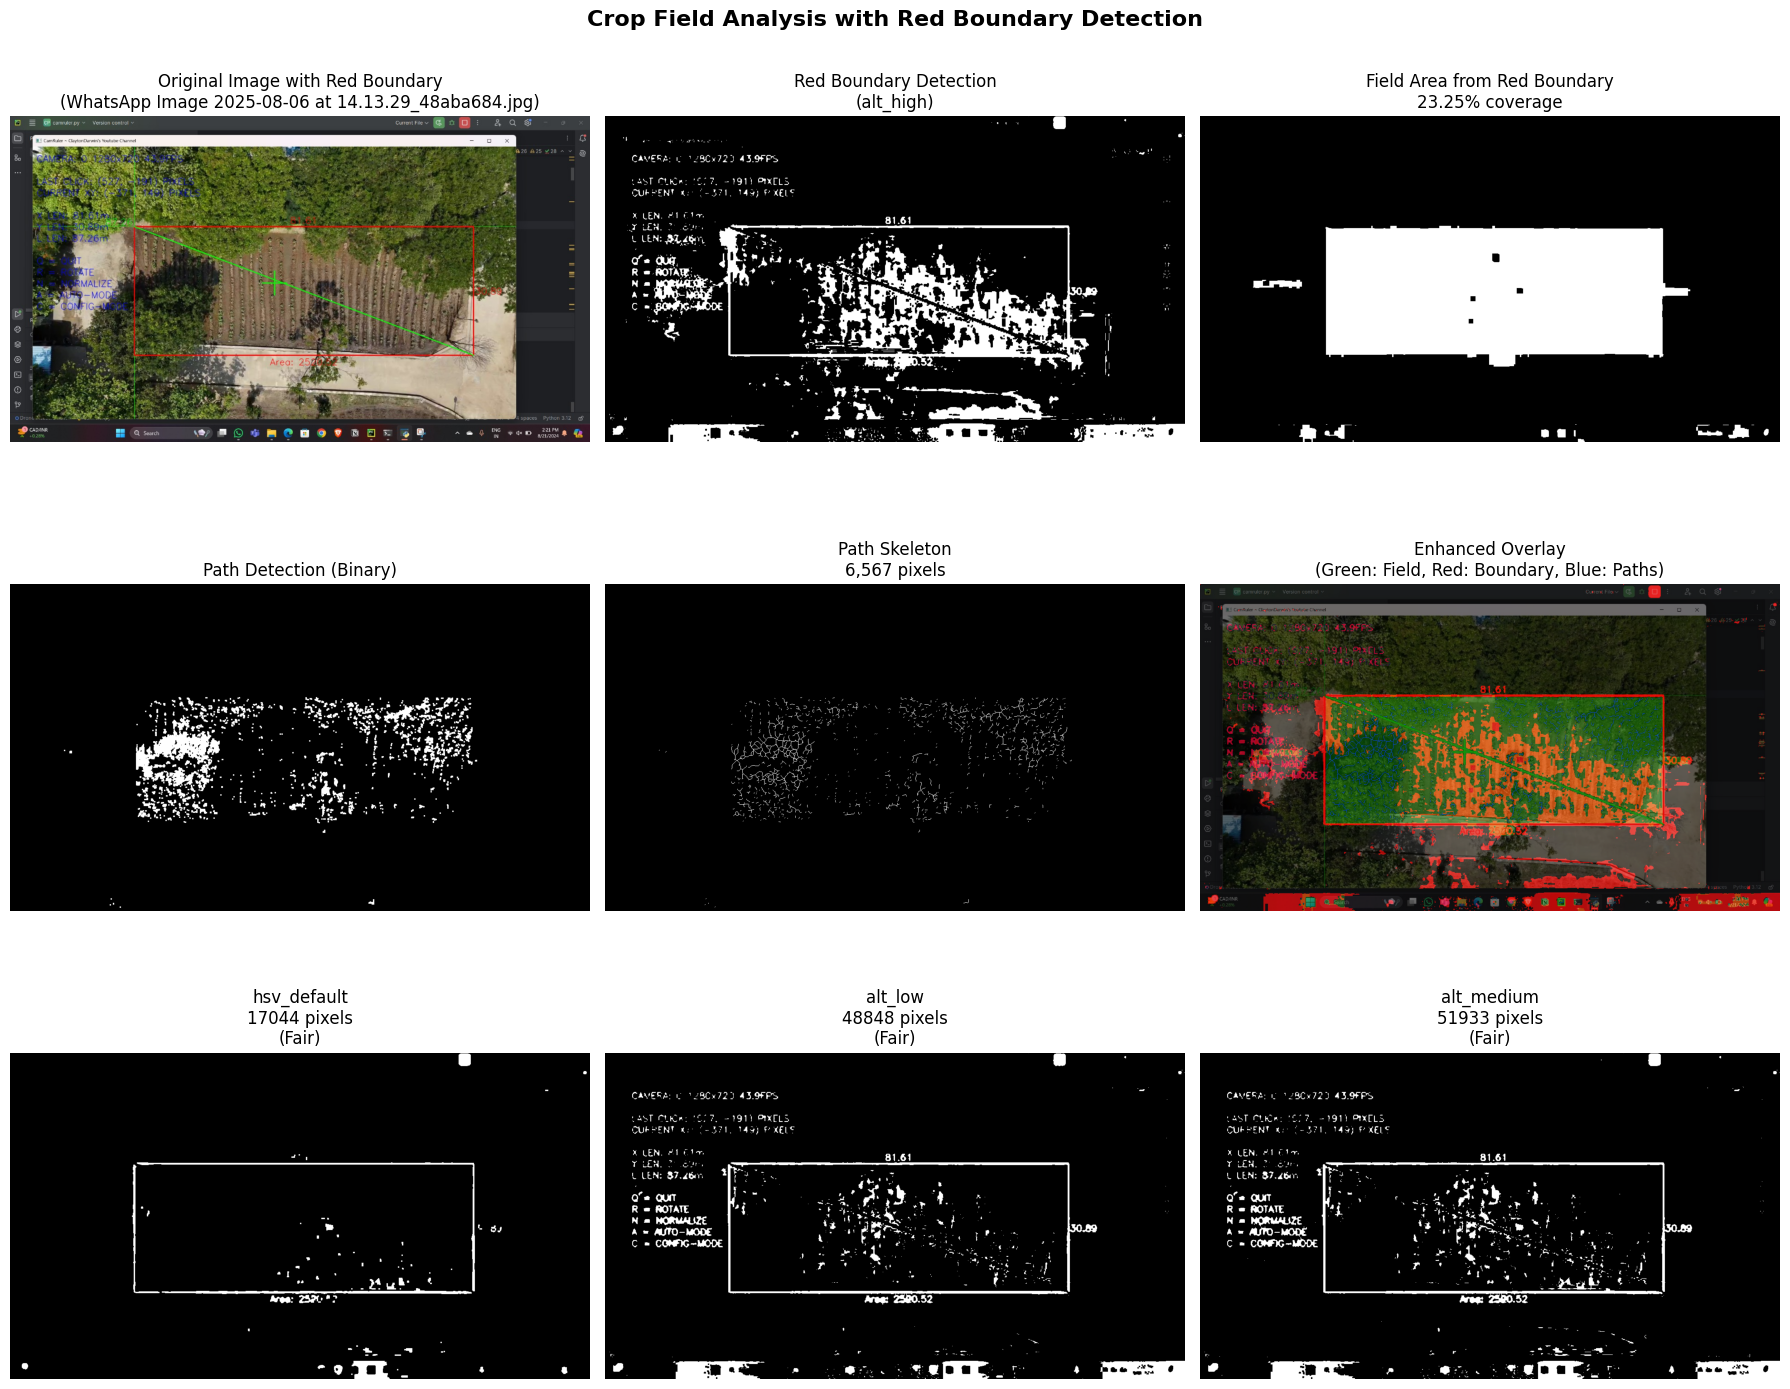

In [ ]:
# Cell 9: Display comprehensive results
def display_red_boundary_analysis():
    """Display comprehensive analysis results with red boundary detection."""
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    fig.suptitle('Crop Field Analysis with Red Boundary Detection', fontsize=16, fontweight='bold')

    # Row 1: Original and red boundary detection
    # Original image
    if len(original_image.shape) == 3:
        display_original = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    else:
        display_original = original_image
    axes[0, 0].imshow(display_original, cmap='gray' if len(original_image.shape) == 2 else None)
    axes[0, 0].set_title(f'Original Image with Red Boundary\n({image_name})')
    axes[0, 0].axis('off')

    # Best red boundary detection
    if best_red_mask is not None:
        axes[0, 1].imshow(best_red_mask, cmap='gray')
        axes[0, 1].set_title(f'Red Boundary Detection\n({best_method})')
    else:
        axes[0, 1].text(0.5, 0.5, 'No Red\nBoundary\nDetected',
                       horizontalalignment='center', verticalalignment='center',
                       transform=axes[0, 1].transAxes, fontsize=12)
        axes[0, 1].set_title('Red Boundary Detection\n(Failed)')
    axes[0, 1].axis('off')

    # Field mask from red boundary
    if best_red_mask is not None:
        axes[0, 2].imshow(final_field_mask, cmap='gray')
        axes[0, 2].set_title(f'Field Area from Red Boundary\n{final_field_percent:.2f}% coverage')
    else:
        axes[0, 2].axis('off')
        axes[0, 2].set_title('Field Area\n(Not Available)')
    axes[0, 2].axis('off')

    # Row 2: Path detection
    if best_red_mask is not None:
        # Path binary
        axes[1, 0].imshow(final_path_binary, cmap='gray')
        axes[1, 0].set_title('Path Detection (Binary)')
        axes[1, 0].axis('off')

        # Path skeleton
        axes[1, 1].imshow(final_path_skeleton, cmap='gray')
        axes[1, 1].set_title(f'Path Skeleton\n{np.count_nonzero(final_path_skeleton):,} pixels')
        axes[1, 1].axis('off')

        # Enhanced overlay
        display_overlay = cv2.cvtColor(enhanced_overlay, cv2.COLOR_BGR2RGB)
        axes[1, 2].imshow(display_overlay)
        axes[1, 2].set_title('Enhanced Overlay\n(Green: Field, Red: Boundary, Blue: Paths)')
        axes[1, 2].axis('off')
    else:
        for i in range(3):
            axes[1, i].axis('off')
            axes[1, i].set_title('Path Analysis\n(Not Available)')

    # Row 3: Method comparison and analysis
    if len(red_detection_results) > 1:
        # Red detection method comparison
        methods = list(red_detection_results.keys())[:3]
        for i, method in enumerate(methods):
            mask = red_detection_results[method]['mask']
            analysis = red_detection_results[method]['analysis']
            axes[2, i].imshow(mask, cmap='gray')
            axes[2, i].set_title(f'{method}\n{analysis["red_pixel_count"]} pixels\n({analysis["boundary_quality"]})')
            axes[2, i].axis('off')

        # Fill remaining plots if less than 3 methods
        for i in range(len(methods), 3):
            axes[2, i].axis('off')
    else:
        for i in range(3):
            axes[2, i].axis('off')

    plt.tight_layout()
    plt.show()

# Display the comprehensive analysis
display_red_boundary_analysis()

In [ ]:
# Cell 10: Statistical summary and quality assessment
def print_red_boundary_analysis_summary():
    """Print comprehensive analysis summary focusing on red boundary detection."""
    print("="*70)
    print("CROP FIELD ANALYSIS WITH RED BOUNDARY DETECTION")
    print("="*70)

    print(f"\n📸 Image Information:")
    print(f"   • Filename: {image_name}")
    print(f"   • Image size: {original_image.shape[1]} x {original_image.shape[0]} pixels")
    print(f"   • Total area: {original_image.shape[0] * original_image.shape[1]:,} pixels")

    if best_red_mask is not None:
        print(f"\n🔴 Red Boundary Detection:")
        print(f"   • Best method: {best_method}")
        print(f"   • Red pixels detected: {np.count_nonzero(best_red_mask):,}")

        # Quality assessment
        analysis = red_detection_results[best_method]['analysis']
        print(f"   • Boundary quality: {analysis['boundary_quality']}")
        print(f"   • Number of contours: {analysis['num_contours']}")

        print(f"\n🌾 Field Area (Red Boundary Based):")
        print(f"   • Field coverage: {final_field_percent:.2f}%")
        print(f"   • Field pixels: {final_field_pixels:,}")
        print(f"   • Non-field area: {100 - final_field_percent:.2f}%")

        print(f"\n🛤️ Path Detection (Within Field):")
        path_pixel_count = np.count_nonzero(final_path_skeleton)
        path_percentage = (path_pixel_count / final_field_pixels) * 100 if final_field_pixels > 0 else 0
        total_path_percentage = (path_pixel_count / (original_image.shape[0] * original_image.shape[1])) * 100

        print(f"   • Path pixels: {path_pixel_count:,}")
        print(f"   • Path coverage (of field): {path_percentage:.3f}%")
        print(f"   • Path coverage (of total): {total_path_percentage:.3f}%")
        print(f"   • Path density: {path_pixel_count / final_field_pixels:.6f} path pixels per field pixel")

        print(f"\n📊 Detection Method Comparison:")
        for method, result in red_detection_results.items():
            analysis = result['analysis']
            print(f"   • {method}: {analysis['red_pixel_count']} pixels ({analysis['boundary_quality']})")

        print(f"\n💡 Recommendations:")
        if analysis['boundary_quality'] == 'Good':
            print("   ✅ Excellent red boundary detection - field area is accurately identified")
        elif analysis['boundary_quality'] == 'Fair':
            print("   ⚠️ Fair red boundary detection - consider improving red line visibility")
        else:
            print("   ❗ Poor red boundary detection - red lines may be too faint or incomplete")

        if final_field_percent > 80:
            print("   ✅ High field coverage detected")
        elif final_field_percent > 50:
            print("   ⚠️ Moderate field coverage - check if boundary is complete")
        else:
            print("   ❗ Low field coverage - boundary may be incomplete or incorrect")

        if path_percentage < 5:
            print("   ✅ Reasonable path density within field")
        else:
            print("   ⚠️ High path density detected - may need path filtering")

    else:
        print(f"\n❌ Red Boundary Detection Failed!")
        print("   • No red boundary lines detected in the image")
        print("   • Make sure the field boundary is marked with bright red lines")
        print("   • Consider using a brighter red color (RGB: 255, 0, 0)")
        print("   • Ensure good image quality and lighting")

    print("\n" + "="*70)

# Print the comprehensive summary
print_red_boundary_analysis_summary()

CROP FIELD ANALYSIS WITH RED BOUNDARY DETECTION

📸 Image Information:
   • Filename: WhatsApp Image 2025-08-06 at 14.13.29_48aba684.jpg
   • Image size: 1280 x 720 pixels
   • Total area: 921,600 pixels

🔴 Red Boundary Detection:
   • Best method: alt_high
   • Red pixels detected: 120,677
   • Boundary quality: Fair
   • Number of contours: 755

🌾 Field Area (Red Boundary Based):
   • Field coverage: 23.25%
   • Field pixels: 214,232
   • Non-field area: 76.75%

🛤️ Path Detection (Within Field):
   • Path pixels: 6,567
   • Path coverage (of field): 3.065%
   • Path coverage (of total): 0.713%
   • Path density: 0.030654 path pixels per field pixel

📊 Detection Method Comparison:
   • hsv_default: 17044 pixels (Fair)
   • alt_low: 48848 pixels (Fair)
   • alt_medium: 51933 pixels (Fair)
   • alt_high: 120677 pixels (Fair)

💡 Recommendations:
   ⚠️ Fair red boundary detection - consider improving red line visibility
   ❗ Low field coverage - boundary may be incomplete or incorrect
   ✅

In [ ]:
# Cell 11: Interactive red boundary parameter tuning
def interactive_red_detection_tuning():
    """
    Interactive function to tune red detection parameters.
    """
    print("🔧 Interactive Red Boundary Detection Tuning")
    print("=" * 50)

    # Get user input for sensitivity
    print("Available sensitivity levels:")
    print("1. Low (more restrictive)")
    print("2. Medium (balanced)")
    print("3. High (more inclusive)")

    try:
        choice = input("\nEnter sensitivity choice (1-3) or 'skip' to use current settings: ")

        if choice == 'skip':
            print("Using current best settings...")
            return

        sensitivity_map = {'1': 'low', '2': 'medium', '3': 'high'}
        sensitivity = sensitivity_map.get(choice, 'medium')

        print(f"Testing with {sensitivity} sensitivity...")

        # Test with new sensitivity
        test_red_mask = alternative_red_boundary_detection(original_image, sensitivity)
        test_field_mask, _, test_pixels, test_percent = detect_field_area_with_red_boundary(
            original_image, 'alternative')

        # Display results
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        axes[0].imshow(test_red_mask, cmap='gray')
        axes[0].set_title(f'Red Detection ({sensitivity})\n{np.count_nonzero(test_red_mask)} pixels')
        axes[0].axis('off')

        axes[1].imshow(test_field_mask, cmap='gray')
        axes[1].set_title(f'Field Mask\n{test_percent:.2f}% coverage')
        axes[1].axis('off')

        # Create overlay
        test_overlay = create_enhanced_overlay(original_image, test_field_mask, test_red_mask,
                                             np.zeros_like(test_field_mask))
        display_overlay = cv2.cvtColor(test_overlay, cv2.COLOR_BGR2RGB)
        axes[2].imshow(display_overlay)
        axes[2].set_title('Result Overlay')
        axes[2].axis('off')

        plt.tight_layout()
        plt.show()

        print(f"Results with {sensitivity} sensitivity:")
        print(f"  • Red pixels: {np.count_nonzero(test_red_mask):,}")
        print(f"  • Field coverage: {test_percent:.2f}%")

    except Exception as e:
        print(f"Error in interactive tuning: {e}")

# Uncomment to run interactive tuning
# interactive_red_detection_tuning()
print("Interactive red detection tuning ready! Uncomment the last line to use it.")

Interactive red detection tuning ready! Uncomment the last line to use it.


Analysis Results Summary:
------------------------------
Image Name: WhatsApp Image 2025-08-06 at 14.13.29_48aba684.jpg
Image Dimensions: 1280x720
Best Red Detection Method: alt_high
Red Pixels Detected: 120677
Field Coverage Percent: 23.24565972222222
Field Pixels: 214232
Path Pixels: 6567
Boundary Quality: Fair


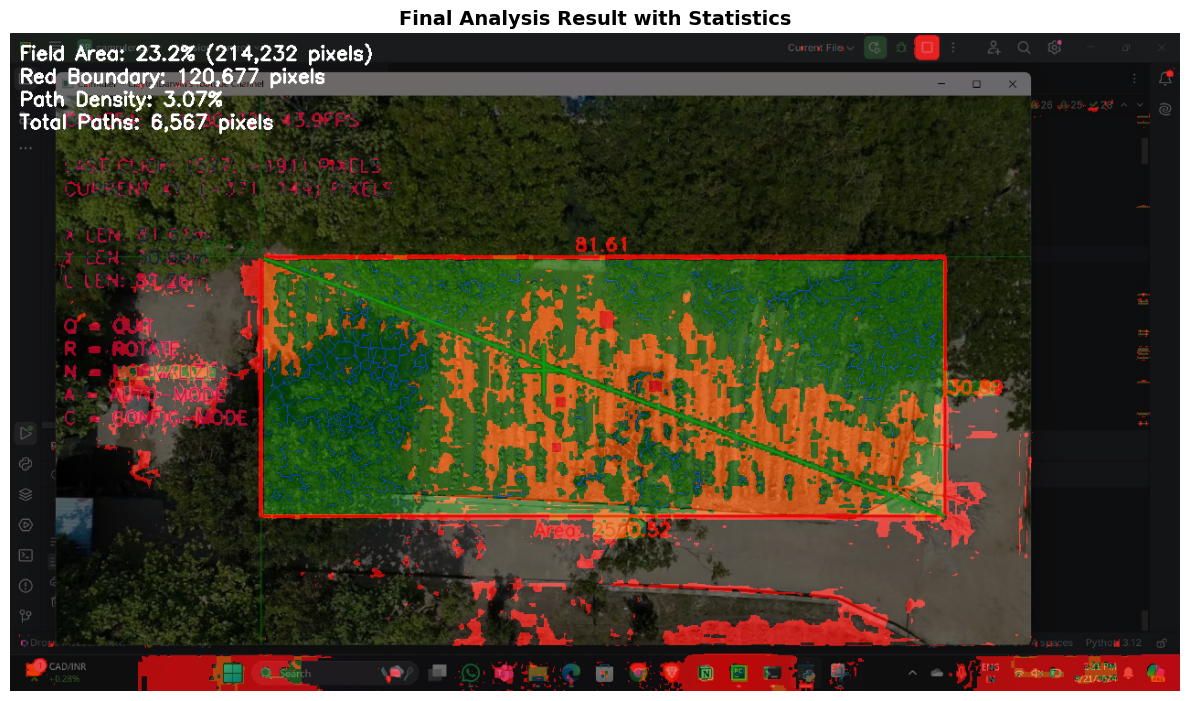

In [ ]:
# Cell 12: Save results and generate report
def save_analysis_results():
    """
    Save analysis results and generate a downloadable report.
    """
    if best_red_mask is not None:
        # Create summary data
        results_data = {
            'image_name': image_name,
            'image_dimensions': f"{original_image.shape[1]}x{original_image.shape[0]}",
            'best_red_detection_method': best_method,
            'red_pixels_detected': int(np.count_nonzero(best_red_mask)),
            'field_coverage_percent': float(final_field_percent),
            'field_pixels': int(final_field_pixels),
            'path_pixels': int(np.count_nonzero(final_path_skeleton)),
            'boundary_quality': red_detection_results[best_method]['analysis']['boundary_quality']
        }

        print("Analysis Results Summary:")
        print("-" * 30)
        for key, value in results_data.items():
            print(f"{key.replace('_', ' ').title()}: {value}")

        # Display final result image
        plt.figure(figsize=(12, 8))
        display_analysis = cv2.cvtColor(analysis_overlay, cv2.COLOR_BGR2RGB)
        plt.imshow(display_analysis)
        plt.title('Final Analysis Result with Statistics', fontsize=14, fontweight='bold')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

        return results_data
    else:
        print("No results to save - red boundary detection failed.")
        return None

# Save and display final results
final_results = save_analysis_results()
